# TDT4173 Project Report

Course: TDT4173 Modern Machine Learning in Practice

Year: 2024

Group name: [55] Ship Happens

Group members:
| Name     | StudentId |
| -------- | ------- |
| Live Krogh  | 123    |
| Ingvild Langeggen  | 123     |
| Alexander Sundquist    | 132896    |

## Table of Contents

 1. [Introduction](#1-introduction)
 2. [Exploratory data analysis](#2-exploratory-data-analysis)
 3. [Feature engineering](#3-feature-engineering)
 4. [Modeling](#4-modeling)
 5. [Model interpretation](#5-model-interpretation)

## 1 Introduction

In the following document the steps taken to complete the TDT4173 Modern Machine Learning in Practice project will be described.

### 1.1 Set-up

In [7]:
import pandas as pd
from datetime import timedelta
import seaborn as sns
import matplotlib.pyplot as plt
#import geopy.distance

The packages that were used in the project were:
- pandas
- datetime
- ...

In [4]:
train = pd.read_csv('ais_train.csv', sep='|')
test = pd.read_csv('ais_test.csv', sep=',')
vessels = pd.read_csv('vessels.csv', sep='|')
ports = pd.read_csv('ports.csv', sep='|')

- The training dataset, `ais_train.csv`, was imported as the dataframe `train`. 
- The test dataset, `ais_test.csv`, was imported as the dataframe `test`. 
- The vessels dataset, `vessels.csv`, was imported as the dataframe `vessels`. 
- The ports dataset, `ports.csv`, was imported as the dataframe `ports`. 

## 2 Exploratory data analysis

Do at least 4 of the following:
- Search domain knowledge
- Check if the data is intuitive
- Understand how the data was generated
- Explore individual features
- Explore pairs and groups of features
- Clean up features
    - Timedate

### 2.1 Search domain knowledge

#### 2.1.1 Vessel speed

Vessels' speed usually varies. Container ships, for example, usually go between 16-24 knots, while some of the fastest cargo ships are able to reach speeds of 37 knots [[1]].


[1]: https://medium.com/@crisri/how-fast-can-large-cargo-ships-go-what-is-the-maximum-speed-that-they-can-safely-travel-at-ae6b1f2c0155

### 2.2 Check if the data is intuitive

#### 2.2.1 `sog`

In [6]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
cog,1522065.0,178.249396,107.678507,0.00000,78.20000,183.80000,269.00000,360.00000
sog,1522065.0,6.331703,7.539364,0.00000,0.00000,0.50000,14.10000,102.30000
rot,1522065.0,0.505456,17.609157,-127.00000,0.00000,0.00000,0.00000,128.00000
heading,1522065.0,176.273681,107.085986,0.00000,75.00000,180.00000,265.00000,511.00000
navstat,1522065.0,2.092604,2.411965,0.00000,0.00000,0.00000,5.00000,15.00000
latitude,1522065.0,36.584970,22.904879,-47.53287,34.51683,42.23370,51.35197,70.55720
longitude,1522065.0,11.536464,68.715718,-167.54093,-5.21281,4.23435,18.83715,178.80538


When checking if the data is intuitive, the `describe` method was used to gain a overview of the numerical values' distribution. `sog` stood out as a potential non-inuitive case due to its high max value. The high speed challenges our gained domain knowledge that would suggest that the fastest vessels travel up to only 37 knots as stated in [2.1.1 Vessel speed](#2.1.1-vessel-speed). Furthermore, the `sog` mean is 6.3 and the 75%-value is only 14.1. Therefore, a max value of 102.3 seems extreme from a distribution perspective as well. This relationship was further examined using a boxplot, as seen below. The plot shows that the right "whisker is somewhere areound 35 knots and that there are multiple values beyond that value. The extreme values would suggest that they are outliers.

<Axes: xlabel='sog'>

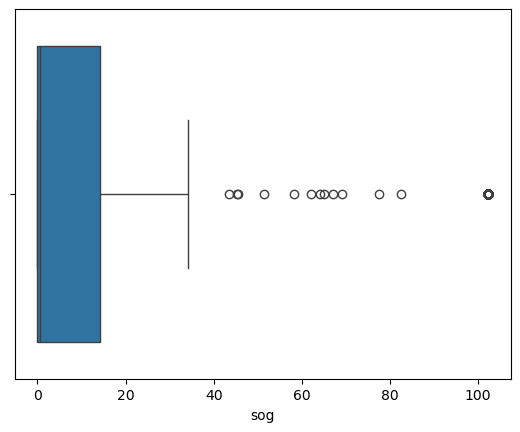

In [8]:
# Plot sog in a boxplot to get an idea of outliers
sns.boxplot(x = 'sog', data = train)

#### 2.2.2 `heading`

In the `describe` table above `heading's` max value also presents an unintuitive characteristic. `heading` represents the heading of the vessel in degrees and should, thus, not be greater than 360. However, when reading the file "Dataset definitions and explanation" it is described that the value 511 indicates that the heading value is not available and is the default value. Therefore, the max value of 511 is probably not an error, but could cause unintuitive interpretation during model training. The number of occurances of 511 in heading was examined by the plot below.

<Axes: xlabel='heading', ylabel='Count'>

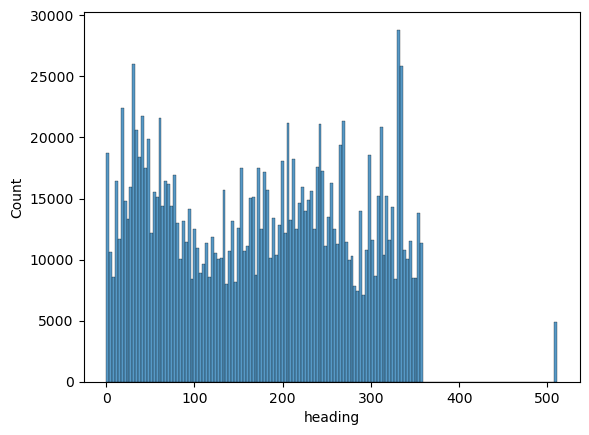

In [9]:
sns.histplot(x='heading', data=train)

### 2.3 Understand how the data was generated

Train vs test 689 vs 200 vessels

### 2.4 Explore individual features

The individual features for each dataset `train`, `test`, `vessels`, `ports`, and `schedules` were examined. First, an overall exploration of all features in each individual dataset was conducted. After, specific features of interest were examined in more detail.

#### 2.4.1 `train`

In [10]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
cog,1522065.0,178.249396,107.678507,0.00000,78.20000,183.80000,269.00000,360.00000
sog,1522065.0,6.331703,7.539364,0.00000,0.00000,0.50000,14.10000,102.30000
rot,1522065.0,0.505456,17.609157,-127.00000,0.00000,0.00000,0.00000,128.00000
heading,1522065.0,176.273681,107.085986,0.00000,75.00000,180.00000,265.00000,511.00000
navstat,1522065.0,2.092604,2.411965,0.00000,0.00000,0.00000,5.00000,15.00000
latitude,1522065.0,36.584970,22.904879,-47.53287,34.51683,42.23370,51.35197,70.55720
longitude,1522065.0,11.536464,68.715718,-167.54093,-5.21281,4.23435,18.83715,178.80538


In [11]:
train.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1522065 entries, 0 to 1522064
Data columns (total 11 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   time       1522065 non-null  object 
 1   cog        1522065 non-null  float64
 2   sog        1522065 non-null  float64
 3   rot        1522065 non-null  int64  
 4   heading    1522065 non-null  int64  
 5   navstat    1522065 non-null  int64  
 6   etaRaw     1522065 non-null  object 
 7   latitude   1522065 non-null  float64
 8   longitude  1522065 non-null  float64
 9   vesselId   1522065 non-null  object 
 10  portId     1520450 non-null  object 
dtypes: float64(4), int64(3), object(4)
memory usage: 127.7+ MB


In [12]:
# Check for null values
train.isnull().sum()

time            0
cog             0
sog             0
rot             0
heading         0
navstat         0
etaRaw          0
latitude        0
longitude       0
vesselId        0
portId       1615
dtype: int64

In [16]:
# Count duplicate rows
print('Number of duplicate rows in train:', len(train)-len(train.drop_duplicates()))

Number of duplicate rows in train: 0


##### 2.4.1.1 `navstat`

In [17]:
# Count the occurence of navstat values
train['navstat'].value_counts()

navstat
0     782099
5     605831
1     129515
2       2081
8        948
15       670
6        521
4        232
3        161
11         2
12         1
13         1
14         1
7          1
9          1
Name: count, dtype: int64

<Axes: xlabel='navstat', ylabel='Count'>

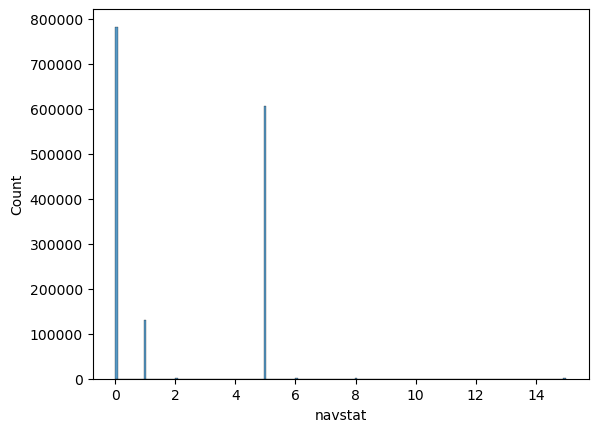

In [18]:
# Plot navstat to visualize the number of each navstat
sns.histplot(x='navstat', data = train)

##### 2.4.1.2 `sog`

<Axes: xlabel='sog'>

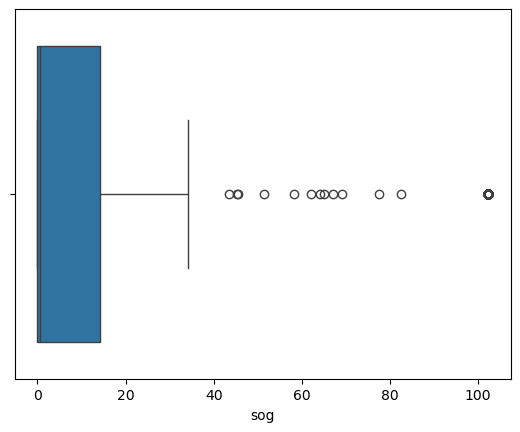

In [19]:
# Plot sog in a boxplot to get an idea of outliers
sns.boxplot(x = 'sog', data = train)

In [23]:
# Count number of rows with sog over 40, which seems to represent the upper outliers
df_sog_greater_40 = train[train['sog'] > 40]    

unique_vessels_sog_greater_40 = df_sog_greater_40['vesselId'].unique()

#print(unique_vessels_sog_greater_40)
print('Number of unique vessels with sog over 40:', len(unique_vessels_sog_greater_40))
print('Number of entries in train with sog over 40:', (train['sog'] > 40).sum())

Number of unique vessels with sog over 40: 33
Number of entries in train with sog over 40: 417


<Axes: xlabel='sog', ylabel='Count'>

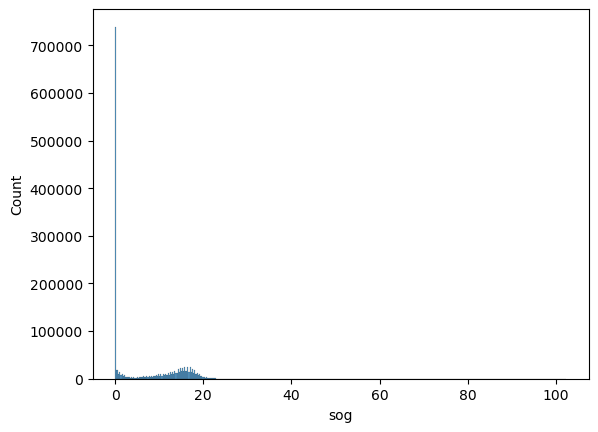

In [20]:
# Plot sog in a histogram
sns.histplot(x='sog',data=train)

In [21]:
# Count the occurence of sog values
train['sog'].value_counts()

sog
0.0     650180
0.1      70767
0.2      18370
0.3      10765
16.0      8906
         ...  
45.2         1
25.3         1
77.5         1
65.0         1
58.2         1
Name: count, Length: 281, dtype: int64

##### 2.4.1.3 `heading`

### 2.5 Explore pairs and groups of features

Correlation plots

scatter plots

plot (index vs feature statistics)

### 2.6 Clean up features

Filled in missing values for portId in train

## 3 Feature engineering

**To avoid the deduction, you should show that you have tried one or more feature engineering techniques (i.e., feature selection and/or feature extraction) in the report.**

For the feature engineering, both feature selection and extraction were conducted. The feature engineering was initially based on the exploratory data analysis but was also adjusted iteratively based on prediction results.

The main function for feature engineering `feature_engineering_heading(test,train)` can be seen below. The function inputs the test dataframe and the train dataframe and returns the dataframe, `features` with the decired features. In the following parts the specific feature selection and extraction that was conducted will be described in more detail.

```python
def feature_engineering_heading(test, train):
    test = test.copy()
    train = train.copy()
    features = pd.DataFrame()

    # Add the columns vesselId, time, latitude, longitude, cog and sog to the features from train
    features['vesselId'] = train['vesselId']
    features['portId'] = train['portId']
    features['time'] = train['time']
    features['etaRaw'] = train['etaRaw']
    features['latitude'] = train['latitude']
    features['longitude'] = train['longitude']
    features['cog'] = train['cog']
    features['sog'] = train['sog']

    # Create a new binary column for 'under_way' based on the navstat column in train. 
    # 1 if navstat is 0 or 8, 0 otherwise
    features['under_way'] = train['navstat'].isin([0, 8]).astype(int)

    # Adding the columns latitude_1 (last seen latitude) and longitude_1 (last senn longitude)
    # to the features from train. For each vessel
    # Also adding time_1 (time difference from current time to last seen time)
    features['latitude_1'] = train.groupby('vesselId')['latitude'].shift(1)
    features['longitude_1'] = train.groupby('vesselId')['longitude'].shift(1)
    features['time_1'] = train.groupby('vesselId')['time'].diff().dt.total_seconds()

    # Adding the columns latitude_2 (second last seen latitude) and longitude_2 (second last seen longitude)
    # to the features from train. For each vessel
    # Also adding time_2 (time difference from current time to second last seen time)
    features['latitude_2'] = train.groupby('vesselId')['latitude'].shift(2)
    features['longitude_2'] = train.groupby('vesselId')['longitude'].shift(2)
    features['time_2'] = train.groupby('vesselId')['time'].diff(2).dt.total_seconds()

    # Adding the columns latitude_3 (third last seen latitude) and longitude_3 (third last seen longitude)
    # to the features from train. For each vessel
    # Also adding time_3 (time difference from current time to third last seen time)
    features['latitude_3'] = train.groupby('vesselId')['latitude'].shift(3)
    features['longitude_3'] = train.groupby('vesselId')['longitude'].shift(3)
    features['time_3'] = train.groupby('vesselId')['time'].diff(3).dt.total_seconds()

    # Apply the conversion function to create a new 'eta' column
    features['eta'] = features.apply(convert_eta_raw, axis=1)

    # Calculate the time difference between 'time' and 'eta' in seconds
    features['time_difference_eta'] = (features['eta'] - features['time']).dt.total_seconds()

    # Split the time column into month, day, hour, minute, and second columns
    features['month'] = train['time'].dt.month
    features['day'] = train['time'].dt.day
    features['hour'] = train['time'].dt.hour
    features['minute'] = train['time'].dt.minute

    # Drop the 'time' and 'etaRaw' columns as they are no longer needed
    features.drop(['time', 'etaRaw'], axis=1, inplace=True)
    features.drop(['eta'], axis=1, inplace=True)

    # Merge the features with the ports
    # Drop rows where portId is null/Nan
    features = features.dropna(subset=['portId'])
    features['portId'] = features['portId'].astype(int)
    features = merge_with_ports(features, ports)

    # Add the feature 'changed_port' to the features.
    # 1 if the vessel has changed port, 0 otherwise
    # features['changed_port'] = features['portId'] != features['portId'].shift(1)

    # Drop the portId column
    # features = features.drop('portId', axis=1)

    # Drop 

    return features
```

### 3.1 Feature selection

When conducting the feature selection, the dataframe `features` was created in the function `feature_engineering_heading(test,train)` where the desired features from the dataframes `train` and `ports` were appended.

#### 3.1.1 Selection from `train`

From `train`, the features `vesselId`, `portId`, `latitude`, `longitude`, `cog`, and `sog` were directly selected. 

The calendar features, `month`, `day`, `hour`, and `minute`, describing the time at which the data point was recorded were also included as seperate featuers. The year and second that were also included in the raw data were, however, left out. The year for all data was 2024 which means that there was no variability and no information to be gained from including the feature. Seconds were to granular to provide any information **(Is this why we did it? just said something lol)**

The features `heading` and `rot` from `train` were not selected as final features. `heading` was not selected due to its high correlation with `cog`, which was deemed to be a more accurate representation of vessel direction **(is this true?)**. `rot` was not included as a feature due to its inclusion reducing performance **(is this true?)**

The features `etaRaw` and `navstat` from `train` were not directly selected but instead used to generate new features, which is described in more detail in [3.2 Feature engineering](#3.2-feature-engineering). `etaRaw` was not selected directly because it proved to be more valuable as a relational feature to `time`. `navstat` was not selected due to it mainly describing two states, under way, given by the feature values 0 and 8 and not under way, given by the feature values 1 and 5.

#### 3.1.2 Selection from `ports`

From `ports`, the features `longitude` and `latitude` were selected, and called `portLongitude` and `portLatitude`. The motivation was to give the model an idea of the vessels final location.

### 3.2 Feature extraction

#### 3.2.1 `under_way`

As mentioned in [3.1.1](#3.1.1-selected-from-train) `navstat` was not selected, but instead used to generate a new feature called `under_way`. The new feature values were set to 1 if the `navstat` value was 0 or 8 and set to 0 in all other cases.

#### 3.2.2 Lag features

The autoregressive lag features `latitude_1` and `longitude_1` was simply the latitude and longitude of the current vessel one time stamp ago. `latitude_2` and `longitude_2` as well as `latitude_3` and `longitude_3` were similirly lag features but from 2 and 3 time steps before, respectively. Lag features were described as beneficial during the lecture on time series and was therefore used in the project. 

### 3.2.3 Time since last seen

Furtermore, in combination with the lag features, the features `time_1`, `time_2`, and `time_3` were generated. The time features describe the time difference from current time to last, second last, and third last seen time. These features describe when the three lagged latitude and longitude features were recorded. This was done because sometimes there could be a big time difference between two following measurements. Intuitively, if previously seen latitude and longitude were a long time ago and the vessel has moved, the data should be less valuable in predicting the next position. The time features allow the model to interpret this pattern. 

#### 3.2.4 Time to arrival

The time to arrival, represented in the feature `time_difference_eta`, was extracted by subtracting the eta with the current time, as seen in the main function `feature_engineering_heading`. Firstly, however, the feature `etaRaw` in `train` had to be preprocessed to allow for the feature extraction, which was done by the function `convert_eta_raw(row)` seen below. `etaRaw` had to be converted to the datetime format and also had to be handled if the `etaRaw` value was earlier than `time` value of when the data was recorded.

```python
# Function to convert 'etaRaw' to datetime format, handling year rollovers
def convert_eta_raw(row):
    current_year = row['time'].year  # Get the year from the 'time' column
    eta_with_year = f"{current_year}-{row['etaRaw']}"  # Create full datetime string
    eta_datetime = pd.to_datetime(eta_with_year, format='%Y-%m-%d %H:%M', errors='coerce')
    
    # Adjust year if 'etaRaw' is earlier than 'time'
    if eta_datetime < row['time']:
        eta_datetime = eta_datetime + timedelta(days=365)
    return eta_datetime
```

#### 3.2.5 Distance to port

The feature `distance_to_port` was calculated in the function `merge_with_ports(features,ports)`, as seen below. `merge_with_ports` was called in the main `feature_engineering_heading` function. `distance_to_port` was calculated with the help of the `geopy` package and allowed the model to interpret distance left to final destination. 

```python
def merge_with_ports(features, ports):
    features = features.copy()

    # Dropping the irrelevant columns in ports
    ports = ports.drop(['name', 'portLocation', 'UN_LOCODE', 'countryName', 'ISO'], axis=1, errors='ignore')

    # Renaming longitude and latitude columns in ports to portLongitude and portLatitude
    ports = ports.rename(columns={'longitude': 'portLongitude', 'latitude': 'portLatitude'})

    # Merging the features with the ports on portId
    features = features.merge(ports, on='portId', how='left')

    # Drop rows with NaN values in latitude and longitude
    features = features.dropna()

    # Calculating the distance between the vessel and the port
    features['distance_to_port'] = features.apply(lambda x: geopy.distance.distance((x['latitude_1'], x['longitude_1']), (x['portLatitude'], x['portLongitude'])).nm, axis=1)


    return features
```

## 4 Modeling

**To avoid the deduction, you should show that you have tried two or more types of predictors in the report (e.g., XGBoost and Random Forest). It is allowed to use only one type of predictor in a short notebook for Kaggle predictions.**

During the data preprocessing and feature engineerng process, the XGBoostRegressor model was used to validate iterations due to its quick run time. When a desirable preprocessing and feature engineering had been completed, a model testing phase was initiated. During testing two types of predictors were tested: XGBoostRegressor and **_____**. The best performing model was selected as the final model. Lastly, hyper-parameter tuning was conducted for the selected model.

### 4.1 Model testing

#### 4.1.1 XGBoost

#### 4.1.2 Other model

### 4.2 Final model

#### 4.2.1 Hyper-parameter tuning

## 5 Model interpretation

To avoid the deduction, you should show one or more model interpretation results (e.g., PDP, feature importance, LIME) in the report.